# Setup and Get Data

### Collect Images Using OpenCV

In [1]:
import os
import time
import uuid
import cv2

In [4]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [5]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

### Setup Albumentations Transform Pipeline

In [7]:
import albumentations as alb

In [8]:
augmentor = alb.Compose([alb.RandomCrop(width=250, height=250), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [9]:
img = cv2.imread(os.path.join('data','train', 'images','0.jpg'))

In [10]:
with open(os.path.join('data', 'train', 'labels', '0.json'), 'r') as f:
    label = json.load(f)

In [11]:
label['shapes'][0]['points']

[[27.501253132832076, 20.050125313283207],
 [184.64411027568923, 207.26817042606515]]

In [12]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [14]:
coords = list(np.divide(coords, [250,250,250,250]))

In [15]:
coords

[0.1100050125313283,
 0.08020050125313283,
 0.7385764411027569,
 0.8290726817042606]

### Apply Augmentations and View Results

In [16]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [17]:
augmented['bboxes'][0][2:]

(0.8899949874686717, 0.9197994987468672)

In [18]:
augmented['bboxes']

[(0.2614235588972431,
  0.17092731829573937,
  0.8899949874686717,
  0.9197994987468672)]

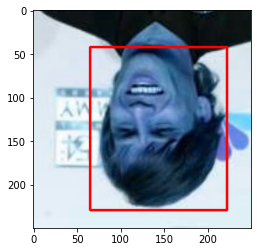

In [19]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [250,250]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [250,250]).astype(int)), 
                    (255,0,0), 2)


plt.imshow(augmented['image'])

## Build and Run Augmentation Pipeline

### Run Augmentation Pipeline

In [20]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [250,250,250,250]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

#### Load Augmented Images to Tensorflow Dataset

In [21]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [22]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [23]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [132]:
# train_images.as_numpy_iterator().next()

## Prepare Labels

### Build Label Loading Function

In [24]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### Load Labels to Tensorflow Dataset

In [25]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [26]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [27]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [28]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.2615, 0.1709, 0.89  , 0.92  ], dtype=float16))

## Combine Label and Image Samples

### Check Partition Lengths

In [29]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(5400, 5400, 600, 600, 360, 360)

### Create Final Datasets (Images/Labels)

In [30]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [31]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [32]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [142]:
# train.as_numpy_iterator().next()[1]

### 7.3 View Images and Annotations

In [33]:
data_samples = train.as_numpy_iterator()

In [43]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


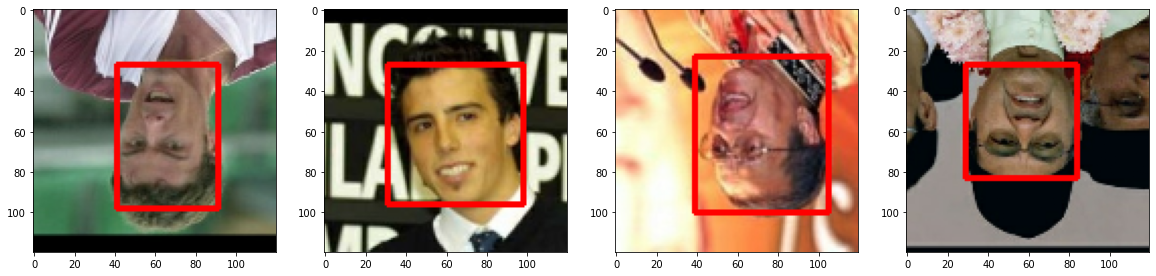

In [44]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# Build Deep Learning using the Functional API

In [45]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [46]:
vgg = VGG16(include_top=False)

In [47]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [48]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [49]:
facetracker = build_model()

In [50]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 120, 120, 3) 0                                            
__________________________________________________________________________________________________
vgg16 (Functional)              (None, None, None, 5 14714688    input_2[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d (GlobalMax (None, 512)          0           vgg16[0][0]                      
__________________________________________________________________________________________________
global_max_pooling2d_1 (GlobalM (None, 512)          0           vgg16[0][0]                      
______________________________________________________________________________________________

In [51]:
X, y = train.as_numpy_iterator().next()

In [52]:
X.shape

(8, 120, 120, 3)

In [53]:
classes, coords = facetracker.predict(X)

In [54]:
classes, coords

(array([[0.601891  ],
        [0.55315435],
        [0.66123617],
        [0.61198205],
        [0.6132002 ],
        [0.64761007],
        [0.6842444 ],
        [0.6076298 ]], dtype=float32),
 array([[0.3651377 , 0.3498848 , 0.3910149 , 0.31574506],
        [0.41634688, 0.26994884, 0.42553088, 0.29310727],
        [0.47105783, 0.32127357, 0.47255597, 0.33734614],
        [0.3848905 , 0.3255568 , 0.40776762, 0.29130936],
        [0.47387436, 0.30461484, 0.5151515 , 0.3422723 ],
        [0.38544238, 0.30551583, 0.51137716, 0.27781177],
        [0.49609172, 0.3282324 , 0.3833631 , 0.35687152],
        [0.47087905, 0.30156162, 0.5225363 , 0.29115635]], dtype=float32))

# Define Losses and Optimizers

### Define Optimizer and LR

In [55]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [56]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

### Create Localization Loss and Classification Loss

In [57]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [58]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

# Train Neural Network

### Create Custom Model Class

In [62]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [63]:
model = FaceTracker(facetracker)

In [64]:
model.compile(opt, classloss, regressloss)

### Train

In [65]:
logdir='logs'

In [66]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [67]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
675/675 [==============================] - 818s 1s/step - total_loss: 0.2148 - class_loss: 0.0760 - regress_loss: 0.1768 - val_total_loss: 10.8212 - val_class_loss: 9.7022 - val_regress_loss: 5.9701
Epoch 2/10
675/675 [==============================] - 812s 1s/step - total_loss: 0.0034 - class_loss: 5.0956e-05 - regress_loss: 0.0034 - val_total_loss: 11.0969 - val_class_loss: 10.4843 - val_regress_loss: 5.8547
Epoch 3/10
675/675 [==============================] - 825s 1s/step - total_loss: 0.0017 - class_loss: 1.6379e-05 - regress_loss: 0.0016 - val_total_loss: 12.7893 - val_class_loss: 13.0520 - val_regress_loss: 6.2633
Epoch 4/10
675/675 [==============================] - 887s 1s/step - total_loss: 0.0013 - class_loss: 8.0462e-06 - regress_loss: 0.0013 - val_total_loss: 12.5988 - val_class_loss: 13.1173 - val_regress_loss: 6.0402
Epoch 5/10
675/675 [==============================] - 926s 1s/step - total_loss: 0.0012 - class_loss: 5.5040e-06 - regress_loss: 0.0012 - val_tot

In [ ]:
# Saving model
facetracker.save('facetracker.h5')

In [ ]:
hist.history

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

### Make Predictions on Test Set

In [1]:
import os
import time
import uuid
import cv2
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [2]:
from tensorflow.keras.models import load_model
facetracker = load_model('facetracker.h5')

In [3]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

test = test_images.shuffle(1300)
test = test.batch(8)

In [4]:
test_data = test.as_numpy_iterator()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


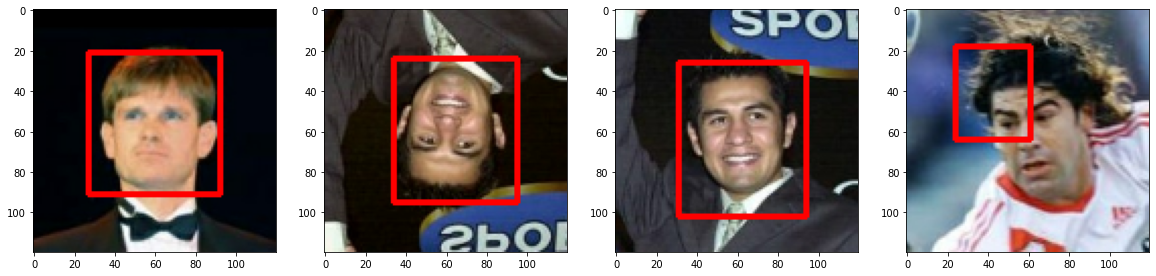

In [12]:
test_sample = test_data.next()

yhat = facetracker.predict(test_sample)

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [10]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [11]:
%tensorboard --logdir logs/train

Reusing TensorBoard on port 6006 (pid 13372), started 0:10:25 ago. (Use '!kill 13372' to kill it.)